# Bitcoin Trading using nueral networks


In this, first part, I want to show how RNNs can be used for financial time series prediction. 

The main code snipset is taken from https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-part-one-simple-time-series-forecasting-f992daa1045a

In this tutorial, we will work with prediction of the bitcoin prices. 


Trade data is available as CSV, delayed by approx. 15 minutes. It will return the 2000 most recent trades.
http://api.bitcoincharts.com/v1/csv/

Following API also retrives the bitcoin prices http://api.bitcoincharts.com/v1/trades.csv?symbol=SYMBOL[&start=UNIXTIME]

The csv file contains 3 fields, unixtime,price,amount



In [31]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D

%matplotlib inline  

In [32]:
import datetime
def convert_to_date(unixtime):
    
 return(
    datetime.datetime.fromtimestamp(
        int(unixtime)
    ).strftime('%Y-%m-%d %H:%M:%S')
)
 


def load_bitcoin_close():
    f = open('1coinUSD.csv', 'rb').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            close_price = float(line.split(',')[1])
            raw_data.append(close_price)
            raw_dates.append(convert_to_date(line.split(',')[0]))
        except:
            continue

    return raw_data, raw_dates

def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]

            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)

            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]

        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y



def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

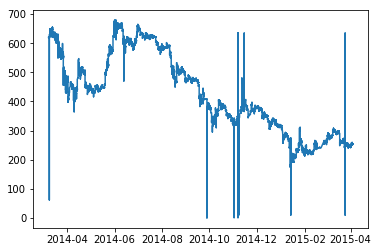

In [33]:
timeseries, dates = load_bitcoin_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in dates]
plt.plot(dates, timeseries)

Data loading...


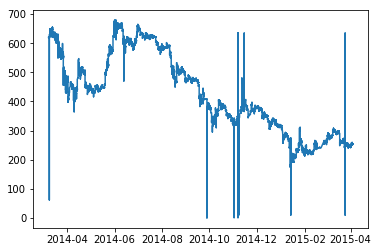

In [34]:
TRAIN_SIZE = 30
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

print 'Data loading...'
timeseries, dates = load_bitcoin_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S').date() for d in dates]
#dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)



In [35]:
print 'Building model...'
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam',
              loss='mse')

model.fit(X_train,
          Y_train,
          nb_epoch=5,
          batch_size = 128,
          verbose=1,
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print score


Building model...
Train on 619415 samples, validate on 68824 samples
Epoch 1/5
619415/619415 [==============================] - 53s - loss: 0.0190 - val_loss: 0.0042

In [36]:
params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

predicted = model.predict(X_test)
new_predicted = []

for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)



72891.2


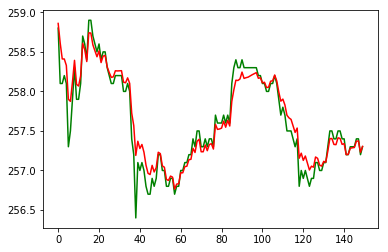

In [37]:
try:
    fig = plt.figure()
    # plt.plot(Y_test[:150], color='black') # black - trained RESULT
  #  plt.plot(predicted[:150], color='blue') # blue - trained PREDICTION
    plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    plt.plot(new_predicted[:150], color='red') # ORANGE - restored PREDICTION
    plt.show()
except Exception as e:
    print str(e)
